# Fit the feature-based choice model

Now we fit a model the generated dataset to recover the features underlying the odd-one-out choices and the corresponding weights for the two raters.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.objects as so

from triplets.fit import (
    parse_args, fit_triplets, 
    save_triplet_results, design_matrix
)
from triplets.embeddings import (
    reconstruct
)

We can fit the model through the command line or within python. Fitting the model on the small generated dataset takes about 10 seconds on my laptop.

## Fitting on the command line

This is the command line option, while hyperparameters are specified in a configuration file:

In [13]:
!fit_triplets.py --config_path example_config.cfg

Namespace(csvfile_items='data/toy_simulation_items.csv', csvfile_raters='data/toy_simulation_raters.csv', csvfile_triplets='data/toy_simulation_triplets.csv', seed=12345, batch_size=128, reg_type=1, lambda_item=0.1, lambda_rater=0.1, max_iter=100, lr=0.1, fold='none', test_rater=None, max_workers=1, verbose=False, device='cpu', num_dims=4, variables_item='index', variables_rater='index', fit_items=True, fit_raters=True, fit_sequence=True, force_positive='softplus', distance='dotproduct', config_path='example_config.cfg', output_folder='example_config', state_dict_path='example_config/model_state.pth')
2 raters, 64 trials, 384 triplets
train loss: 0.06975433975458145, train accuracy: 0.9947916666666666
Results saved to example_config/results.csv


This command fits the model and saves the item scores and rater weights in a folder named like the configuration file. We load and plot them in the following:

In [14]:
df_items = pd.read_csv('example_config/item_embeddings.csv',index_col=0)
df_items_long = df_items.melt(
    id_vars=['index','hue_c','brightness_c','rounding_c','size_c'],
    value_vars=[f'emb{ii}' for ii in range(4)],
    value_name='score', var_name='feature'
)
df_raters = pd.read_csv('example_config/rater_embeddings.csv',index_col=0)
df_rater_long = df_raters.melt(
    id_vars=['index'],
    value_vars=[f'emb{ii}' for ii in range(4)],
    value_name='weight', var_name='feature'
)
df_rater_long['rater'] = df_rater_long['index'].astype(str)

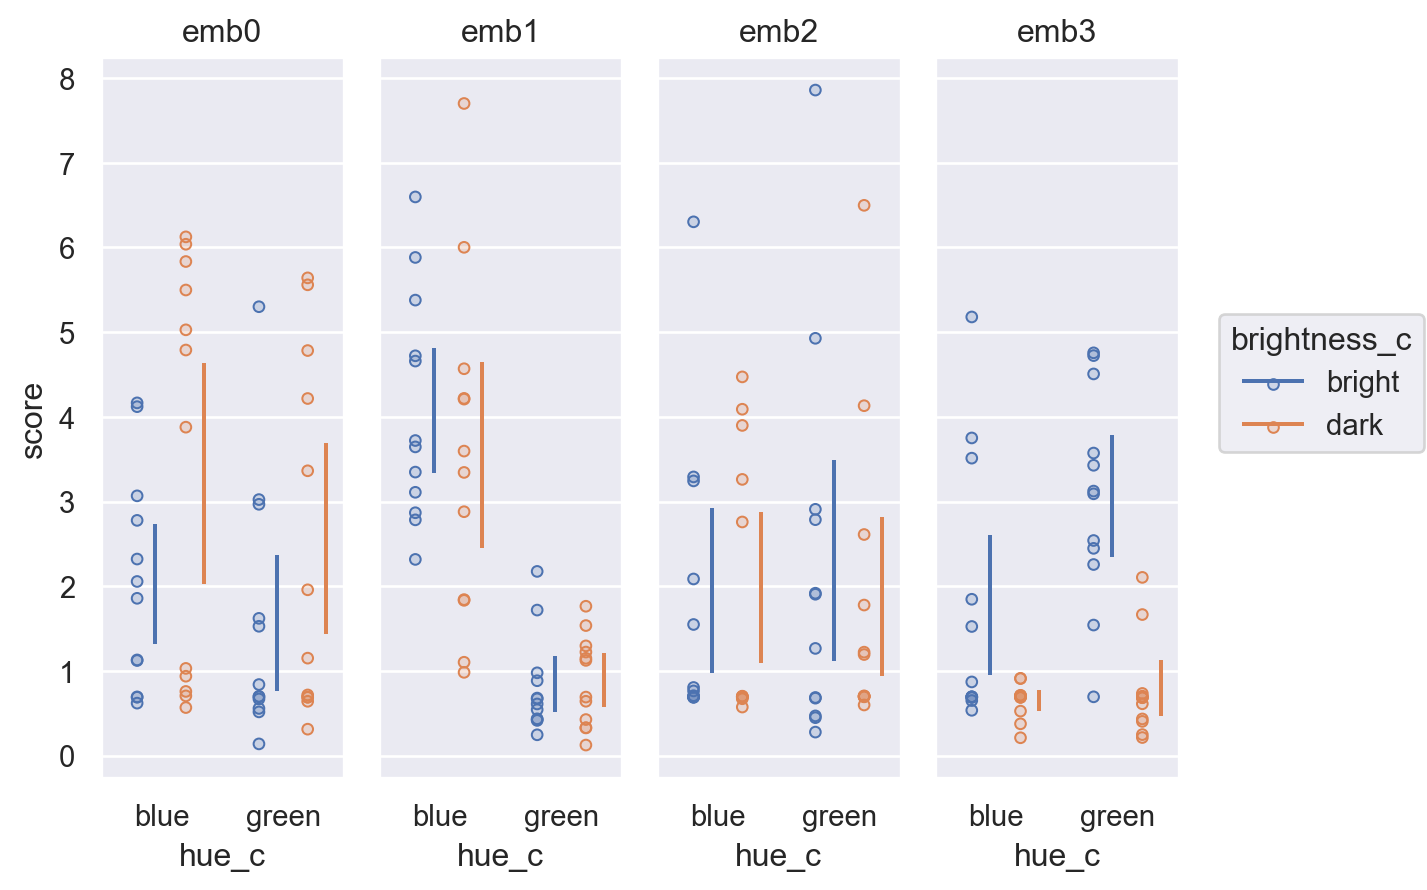

In [15]:
p = (
    so.Plot(
        df_items_long, x='hue_c', y='score', color='brightness_c'
    )
    .facet(col='feature')
    .add(so.Dots(),so.Dodge())
    .add(so.Range(),so.Est(),so.Dodge(),so.Shift(.15))
)
p.plot()

Here we plotted the item scores separated by hue and brightness categories. We see that features 1 and 3 capture these variables respectively.

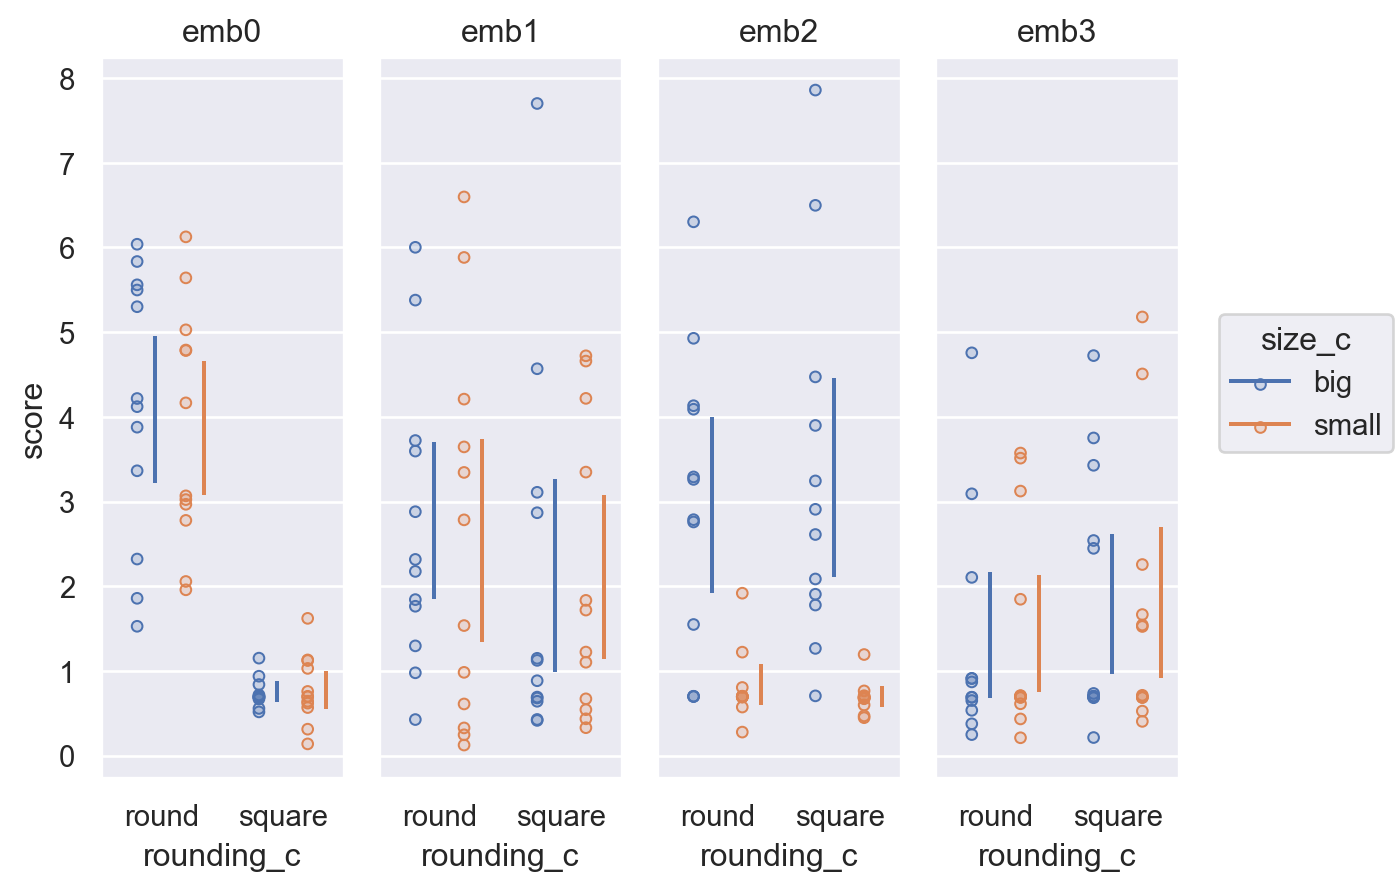

In [16]:
p = (
    so.Plot(
        df_items_long, x='rounding_c', y='score', color='size_c'
    )
    .facet(col='feature')
    .add(so.Dots(),so.Dodge())
    .add(so.Range(),so.Est(),so.Dodge(),so.Shift(.15))
)
p.plot()

Here we plotted the item scores separated by rounding and size categories. We see that features 2 and 4 capture these variables respectively.

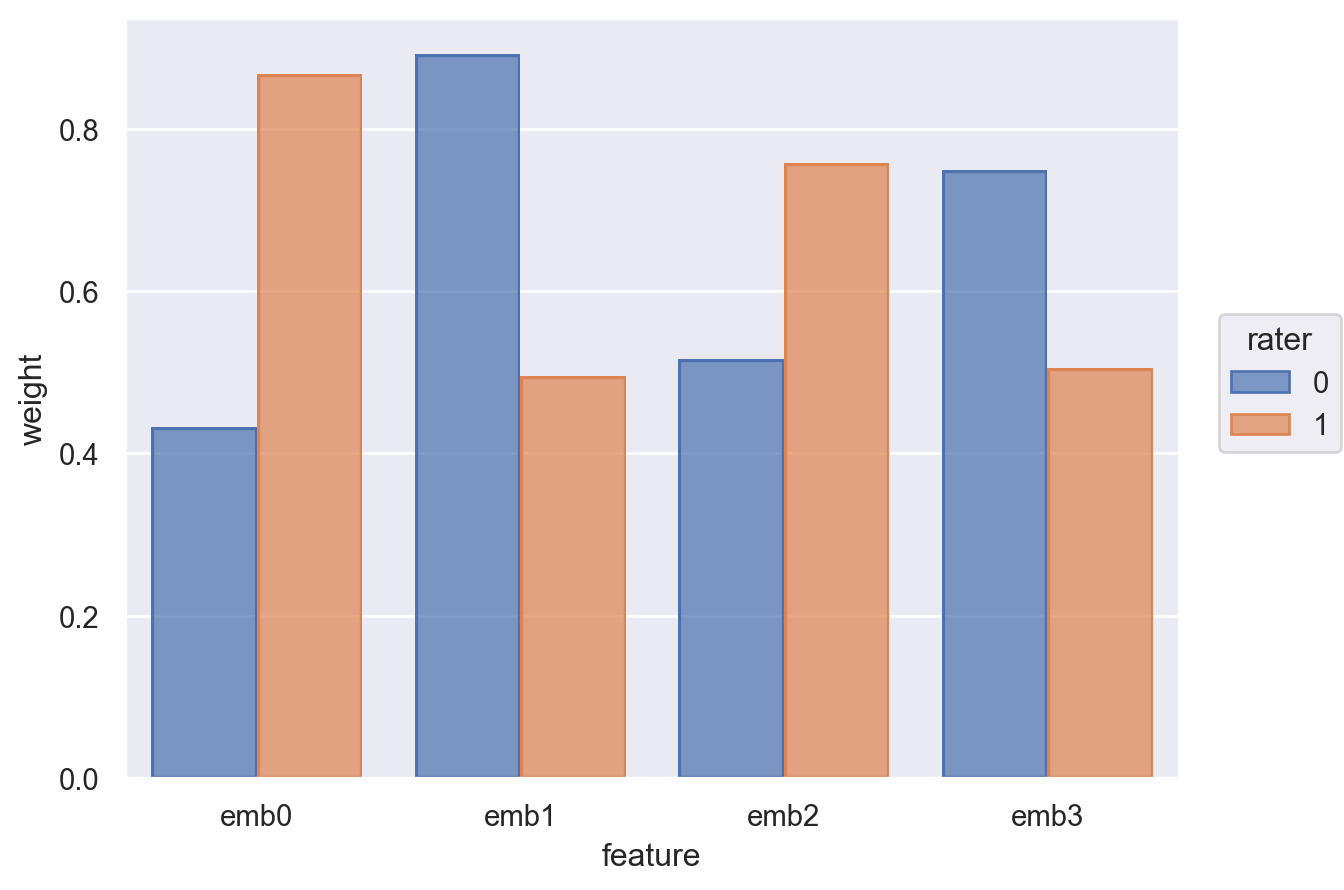

In [17]:
p = (
    so.Plot(
        df_rater_long, x='feature', y='weight', color='rater'
    )
    .add(so.Bar(),so.Dodge())
)
p.plot()

Here we plotted the fitted rater weights for both raters across features. We see a pattern that follows the ground truth simulation: the first rater puts more weight on the two features associated with color (features 1 & 3, *hue* & *brightness*), whereas the second rater puts more weight on shape features (features 2 & 4, *rounding* & *size*).

## Fitting within python

To fit the model in python, we first load the configuration file.

In [18]:
args = parse_args(args='', config_path='example_config.cfg')
print(args)

Namespace(csvfile_items='data/toy_simulation_items.csv', csvfile_raters='data/toy_simulation_raters.csv', csvfile_triplets='data/toy_simulation_triplets.csv', seed=12345, batch_size=128, reg_type=1, lambda_item=0.1, lambda_rater=0.1, max_iter=100, lr=0.1, fold='none', test_rater=None, max_workers=1, verbose=False, device='cpu', num_dims=4, variables_item='index', variables_rater='index', fit_items=True, fit_raters=True, fit_sequence=True, force_positive='softplus', distance='dotproduct', config_path='example_config.cfg', output_folder='example_config', state_dict_path='example_config/model_state.pth')


Now we make some changes, this time we are fitting the model with a design matrix that contains the categorical color and shape variables, but we don't fit individual items.

In [19]:
args.variables_item = 'hue_c+brightness_c+rounding_c+size_c'

During fitting this option will generate a design matrix like this:

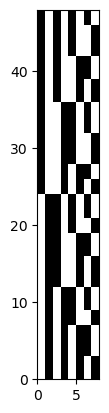

In [20]:
design = design_matrix(df_items, args.variables_item)
fig, ax = plt.subplots()
ax.pcolormesh(design, cmap='gray')
ax.set_aspect(1)
fig.show()

In [21]:
results, _ = fit_triplets(args)
outpath = save_triplet_results(results, args)
df_items, df_raters, columns, df_weights = reconstruct(args, outpath)

2 raters, 64 trials, 384 triplets
train loss: 0.6166363557179769, train accuracy: 0.7369791666666666


We see that, this time, we cannot fit all the odd-one-out choices (the training accuracy stays at .75) since the model is more restricted.

We plot the item scores in the following:

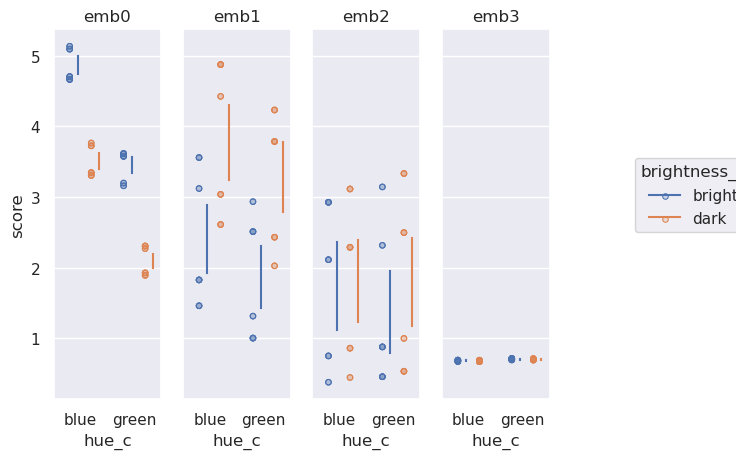

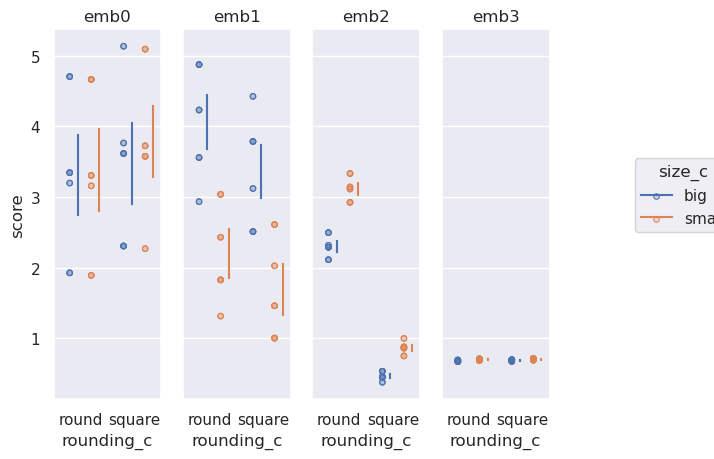

In [22]:
df_items_long = df_items.melt(
    id_vars=['hue_c','brightness_c','rounding_c','size_c'],
    value_vars=[f'emb{ii}' for ii in range(4)],
    value_name='score', var_name='feature'
)
fig1 = plt.figure()
fig2 = plt.figure()
p = (
    so.Plot(
        df_items_long, x='hue_c', y='score', color='brightness_c'
    )
    .facet(col='feature')
    .add(so.Dots(),so.Dodge())
    .add(so.Range(),so.Est(),so.Dodge(),so.Shift(.15))
    .on(fig1)
)
p.plot()
p = (
    so.Plot(
        df_items_long, x='rounding_c', y='score', color='size_c'
    )
    .facet(col='feature')
    .add(so.Dots(),so.Dodge())
    .add(so.Range(),so.Est(),so.Dodge(),so.Shift(.15))
    .on(fig2)
)
p.plot()
fig1.show()
fig2.show()

We see that this time only the categories as a whole were fitted and not the individual items. This is useful in model comparisons to test how much prior knowledge can explain the odd-one-out choices.